In [1]:
%load_ext blackcellmagic

In [2]:
import os
import cv2 
import types
import warnings 
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
    Callback
)
from keras.datasets import mnist, fashion_mnist, cifar10, cifar100
from keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Dense,
    Input,
    MaxPooling2D,
    UpSampling2D,
)
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from keras.utils.multi_gpu_utils import multi_gpu_model
from itertools import chain

from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
np.random.seed(42)

In [4]:
ANOMALY_STR ="anomaly"
NORMAL_STR = "normal"
USE_CASE ="cable"
img_path = os.path.join("imgs",USE_CASE)
if not os.path.isdir(img_path):
    os.mkdir(img_path)
ckpt_path = os.path.join("ckpts",USE_CASE)
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)
data_path = os.path.join(os.getcwd(),"data","mvtec_anomaly_detection")
base_log_dir= os.path.join("logs",USE_CASE)

if not os.path.isdir(base_log_dir):
    os.mkdir(base_log_dir)


classes = list(filter(lambda d:os.path.isdir(os.path.join(data_path,d)),  os.listdir(data_path)))
classes

['bottle',
 'cable',
 'capsule',
 'carpet',
 'grid',
 'hazelnut',
 'leather',
 'metal_nut',
 'pill',
 'screw',
 'tile',
 'toothbrush',
 'transistor',
 'wood',
 'zipper']

# Preparing the data

In [5]:
object_categories = ["bottle","cable","capsule","metal_nut","pill","screw","tile","toothbrush","transistor","zipper"]

In [6]:
def read_image_file_names(dir_path):
    """Reads images per category for given directory path.
    Returns images as a generator object in intervall[0,1] rgb-format"""
    # data = np.empty(shape=(0,1,1,3),dtype=np.int8)
    cur_shape= None
    path_to_dir = os.path.join(os.getcwd(),dir_path)
    return [os.path.join(path_to_dir,p) for p in os.listdir(dir_path)]

In [7]:
def get_path_to_data(mode):
    if mode == "validation":
        mode = "test"
    normal_path = os.path.join(data_path, USE_CASE, mode)
    print(normal_path)
    return normal_path

In [8]:
def load_data():
    normal_path = os.path.join(data_path, USE_CASE, "train", "good")
    normal_train_data = read_image_file_names(normal_path)
    
    test_path = os.path.join(data_path,USE_CASE,"test")
    normal_test_data = read_image_file_names(os.path.join(test_path,"good"))
    anomaly_test_data = []
    for p in os.listdir(test_path):
        if p != "good":#    
            gen = read_image_file_names(os.path.join(test_path,p))
            anomaly_test_data +=  read_image_file_names(os.path.join(test_path,p))
    return normal_train_data, normal_test_data,normal_test_data, anomaly_test_data

In [9]:
X_normal_train, X_normal_validate, X_normal_test, X_anomaly_test = load_data()
X_normal_train[:5] # contains only (absolute) file paths to the data

['C:\\Users\\danie\\coding\\cnn-auto-encoder\\data\\mvtec_anomaly_detection\\cable\\train\\good\\000.png',
 'C:\\Users\\danie\\coding\\cnn-auto-encoder\\data\\mvtec_anomaly_detection\\cable\\train\\good\\001.png',
 'C:\\Users\\danie\\coding\\cnn-auto-encoder\\data\\mvtec_anomaly_detection\\cable\\train\\good\\002.png',
 'C:\\Users\\danie\\coding\\cnn-auto-encoder\\data\\mvtec_anomaly_detection\\cable\\train\\good\\003.png',
 'C:\\Users\\danie\\coding\\cnn-auto-encoder\\data\\mvtec_anomaly_detection\\cable\\train\\good\\004.png']

In [10]:
def plot_mvtec(data):
    plt.imshow(data)

In [11]:
def hide_axis(subplt, x=True, y=True):
    if x:
        subplt.get_xaxis().set_visible(False)
    if y:
        subplt.get_yaxis().set_visible(False)

In [12]:
def train_img_generator(
    file_paths, batch_size, input_only=False
):
    # yields batch_size-d arrays of images indefinetly
    # order of images is random.
    # ONLY FOR TRAIN AND EVALUATE PURPOSES SUITABLE
    while True:
        inds = (np.random.randint(0, len(file_paths), batch_size))
        imgs = np.array([])
        for i in inds:
            fp = file_paths[i]
            if os.path.isfile(fp):
                img = cv2.imread(fp)  # reads an image in the BGR format
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
                imgs = (
                    np.concatenate((imgs, np.array([img])))
                    if imgs.size > 0
                    else np.array([img])
                )
        if not input_only:
            yield imgs / 255, imgs / 255
        else:
            yield imgs / 255

In [13]:
def img_generator(file_paths, n):
    # returns generator of n images
    imgs = np.array([])
    if len(file_paths)< n:
        # prevent an IndexError
        n = len(file_paths)
        
    for i in range(n):
            fp = file_paths[i]
            if os.path.isfile(fp):
                img = cv2.imread(fp)  # reads an image in the BGR format
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
                yield img /255

In [14]:
def plot_samples(row_one, row_two, f_plot, outfile=""):
    """Plot 8 sample images of the row_one and row_two"""
    plt.figure(figsize=(16, 4))
    # row_one
    n = 8
    for i in range(n):
        try:
            ax = plt.subplot(2, n, i+1)
            hide_axis(ax)
            nxt = next(row_one) if isinstance(row_one, types.GeneratorType) else row_one[i]
            f_plot(nxt) # row_one
        except IndexError:
            pass
        try:
            ax = plt.subplot(2, n, n+i+1)
            hide_axis(ax)
            nxt = next(row_two) if isinstance(row_two,types.GeneratorType) else row_two[i]
            f_plot(nxt) # row_two
        except IndexError:
            pass
    if outfile!="":
        plt.savefig(outfile)

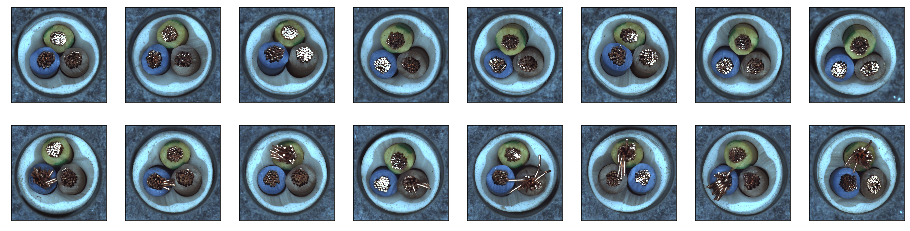

In [15]:
path = os.path.join(img_path, "{}-{}.png".format(NORMAL_STR, ANOMALY_STR))
plot_samples(
    img_generator(X_normal_test, 8), img_generator(X_anomaly_test, 8), plot_mvtec, path
)

# Extracting features with an auto encoder (ae)

In [16]:
def get_codec_from_ae(autoencoder):
    encoder_layer = autoencoder.get_layer("encoder")
    # this model maps an input to its encoded representation; Big image to small rep
    encoder = Model(
        inputs=autoencoder.input, outputs=encoder_layer.output)

    # create a placeholder for an encoded (ENCODING_DIM-dimensional) input
    encoded_input = Input(shape=encoder_layer.output_shape[1:])

    # getting the middle of the autoencoder
    start = (len(autoencoder.layers))//2
    decoder = autoencoder.layers[-start](encoded_input)
    # stacking the decoder layers
    for i in range(start-1, 0, -1):
        decoder = autoencoder.layers[-i](decoder)

    # create the decoder model; "<": encoded(small) representation to big image
    decoder = Model(encoded_input, decoder)
    return encoder, decoder

In [17]:
def build_conv_ae(
    filters, input_shape=(28, 28, 1), kernel=(3, 3), pool_size=(2, 2), color="gray"
):
    # STRETCH GOAL: variable number of layers and pool_size
    pool_size = (2, 2)
    kernel = (3, 3)
    if len(filters) != 4:
        raise ValueError("Four Filters must be given. Sorry.")
    # this is our input placeholder
    input_img = Input(shape=input_shape)
    # layer between input and middle layer
    i = 0
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(input_img)
    encode = MaxPooling2D(pool_size, padding="same")(encode)
    i += 1
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(encode)
    encode = MaxPooling2D(pool_size, padding="same")(encode)
    i += 1
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(encode)
    encode = MaxPooling2D(pool_size, padding="same")(encode)
    i += 1
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(encode)

    # "encoded" is the encoded representation of the input, middle layer of the aue
    encoded = MaxPooling2D(pool_size, padding="same", name="encoder")(encode)

    # layer between middle and output layer
    decode = Conv2DTranspose(filters[i], kernel, activation="relu", padding="same")(encoded)
    decode = UpSampling2D(pool_size)(decode)
    i -= 1
    decode = Conv2DTranspose(filters[i], kernel, activation="relu", padding="same")(decode)
    decode = UpSampling2D(pool_size)(decode)
    i -= 1
    decode = Conv2D(filters[i], kernel, activation="relu", padding="same")(decode)
    decode = UpSampling2D(pool_size)(decode)
    i -= 1
    decode = Conv2D(filters[i], kernel, activation="relu", padding="same")(decode)
    decode = UpSampling2D(pool_size)(decode)
    decoded = Conv2D(
        1 if color == "gray" else 3, kernel, activation="sigmoid",padding="same"
    )(decode)

    # this model maps an input to its reconstruction
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder_single = Model(inputs=input_img, outputs=decoded)
    
    encoder, decoder = get_codec_from_ae(autoencoder_single)
    # autoencoder = multi_gpu_model(autoencoder_single, 4)

    # build (aka "compile") the model
    autoencoder.compile(optimizer="adadelta", loss="mse")
    # autoencoder_single.compile(optimizer="adadelta", loss="mse")
    return autoencoder,autoencoder_single, encoder, decoder

## Training the feature extractor auto encoder

In [18]:
class ModelCkptMultiGPU(Callback):
    """Save the model after every epoch.
    `filepath` can contain named formatting options,
    which will be filled with the values of `epoch` and
    keys in `logs` (passed in `on_epoch_end`).
    For example: if `filepath` is `weights.{epoch:02d}-{val_loss:.2f}.hdf5`,
    then the model checkpoints will be saved with the epoch number and
    the validation loss in the filename.
    # Arguments
        filepath: string, path to save the model file.
        monitor: quantity to monitor.
        verbose: verbosity mode, 0 or 1.
        save_best_only: if `save_best_only=True`,
            the latest best model according to
            the quantity monitored will not be overwritten.
        save_weights_only: if True, then only the model's weights will be
            saved (`model.save_weights(filepath)`), else the full model
            is saved (`model.save(filepath)`).
        mode: one of {auto, min, max}.
            If `save_best_only=True`, the decision
            to overwrite the current save file is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc. In `auto` mode, the direction is
            automatically inferred from the name of the monitored quantity.
        period: Interval (number of epochs) between checkpoints.
    """

    def __init__(self, filepath,model, monitor='val_loss', verbose=0,
                 save_best_only=False, save_weights_only=False,
                 mode='auto', period=1):
        #super(ModelCheckpoint, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0
        self.model_to_save = model

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('ModelCheckpoint mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch + 1, self.monitor, self.best,
                                     current, filepath))
                        self.best = current
                        if self.save_weights_only:
                            self.model_to_save.save_weights(filepath, overwrite=True)
                        else:
                            self.model_to_save.save(filepath, overwrite=True)
                    else:
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s did not improve from %0.5f' %
                                  (epoch + 1, self.monitor, self.best))
            else:
                if self.verbose > 0:
                    print('\nEpoch %05d: saving model to %s' % (epoch + 1, filepath))
                if self.save_weights_only:
                    self.model_to_save.save_weights(filepath, overwrite=True)
                else:
                    self.model_to_save.save(filepath, overwrite=True)

In [24]:
ckpt_loc = os.path.join(ckpt_path,"feature-extractor-ae-img-preproc.hdf5")
log_dir = os.path.join(base_log_dir,str(len(os.listdir(base_log_dir))))
if not os.path.isdir(log_dir):
    os.mkdir(log_dir)
    
if os.path.isfile(ckpt_loc):
    print("Loading Autoencoder for %s feature extraction from directory %s..." % (USE_CASE,ckpt_loc))
    ae = load_model(ckpt_loc)

    # this needs to be compiled since the untrained, single-GPU model is saved instead of the multi-GPU model
    ae.compile(optimizer="adadelta", loss="mse") 
    encoder, decoder = get_codec_from_ae(ae)
    # ae.summary()    
else:
    print("Writing logs to %s" % log_dir)
    print("Training Autoencoder for %s feature extraction..." % USE_CASE)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2)
    train_generator = train_datagen.flow_from_directory(
        get_path_to_data("train"),
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',subset="training")
    
    validation_generator = train_datagen.flow_from_directory(
        get_path_to_data("train"),
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',subset="validation")
    input_shape= (256,256,3)# next(img_generator(X_normal_test,1)).shape # retrieve sample image to determine shape of images

    ae,ae_single, encoder, decoder = build_conv_ae(input_shape=input_shape,filters=[8,8,4,2],color="not-gray")
    earlyStopping = EarlyStopping(
        monitor="val_loss", patience=20, verbose=1, mode="min", min_delta=(1/10**6)
    )
    mcp_save = ModelCkptMultiGPU(
        ckpt_loc, ae_single, save_best_only=True, verbose=1, monitor="val_loss", mode="min"
    )
    reduce_lr_loss = ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=5, verbose=1, mode="min"
    )
    tb = TensorBoard(
        log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True
    )
    ae.summary()   
    ae.fit_generator(
        generator=train_generator,# needs to produce data infinitely
        epochs=128,
        steps_per_epoch=256,
        shuffle=True,
        validation_data=validation_generator,
        validation_steps=64,
        callbacks=[mcp_save,earlyStopping,reduce_lr_loss, tb]
    )

Writing logs to logs\cable\46
Training Autoencoder for cable feature extraction...
C:\Users\danie\coding\cnn-auto-encoder\data\mvtec_anomaly_detection\cable\train
Found 180 images belonging to 1 classes.
C:\Users\danie\coding\cnn-auto-encoder\data\mvtec_anomaly_detection\cable\train
Found 44 images belonging to 1 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 256, 256, 8)       224       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_14

KeyboardInterrupt: 

TODO:
 - [x] fix model saving
 - [ ] fix parametrised ae building

## Evaluating the feature extractor

**Problem** with evaluation: batch size of 4 is evaluated, batches are chosen randomly,
Consequence: some samples are evaluated more than once, some never

In [19]:
def evaluate_ae(ae, X_train, X_test):
    eval_train = ae.evaluate_generator(train_img_generator(X_train, 4),steps=len(X_train))
    eval_test = ae.evaluate_generator(train_img_generator(X_test, 4),steps=len(X_test))
    return eval_train, eval_test

In [20]:
eval_train, eval_test = evaluate_ae(
    ae, X_normal_train, X_normal_test
) # estimated time: ~1 min, since one epoch of data needs to be processed
eval_train, eval_test

(0.005192357211074393, 0.004910093242430995)

In [21]:
def predict_from_generator(model, gen):
    predictions = np.array([])
    for g in gen:
        pred = model.predict(g.reshape((1,*g.shape)))
        predictions = np.concatenate((predictions, pred)) if predictions.size > 0 else pred    
    return predictions

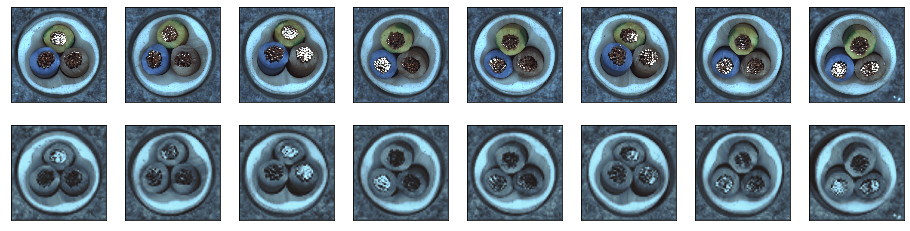

In [22]:
samples_normal = img_generator(X_normal_test,8)
decoded_samples_normal = predict_from_generator(ae, samples_normal)
plot_samples(
    img_generator(X_normal_test,8),
    decoded_samples_normal,
    plot_mvtec,
    os.path.join(img_path, "rec-{}.png".format(NORMAL_STR)),
)

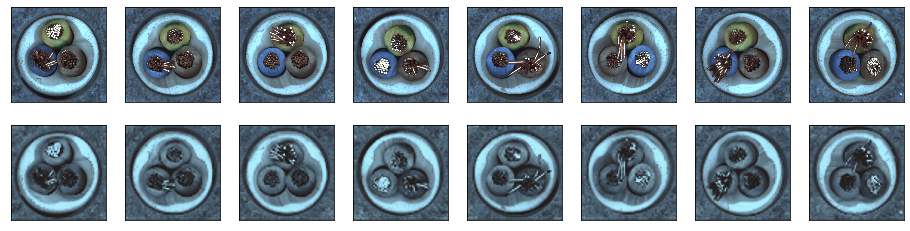

In [23]:
samples_anomaly = img_generator(X_anomaly_test,8)
decoded_samples_anomaly = predict_from_generator(ae, samples_anomaly)

plot_samples(
    img_generator(X_anomaly_test,8),
    decoded_samples_anomaly,
    plot_mvtec,
    os.path.join(img_path, "rec-{}.png".format(ANOMALY_STR)),
)

# Anomaly detection
## Loss based
### Computing the reconstruction loss for anomalies and normalities

In [24]:
def loss_per_img(img,rec_img):
    # mean squared error
    return  np.sum(np.power(rec_img - img, 2)) / (np.prod(img.shape) -1)

In [25]:
samples_normal = img_generator(
    X_normal_test, len(X_normal_test)
)  
decoded_samples_normal = predict_from_generator(ae, samples_normal)
normal_losses = np.array(
    [
        loss_per_img(i, ri)
        for i, ri in zip(
            img_generator(X_normal_test, len(X_normal_test)), decoded_samples_normal
        )
    ]
)

samples_anomaly = img_generator(
    X_anomaly_test, len(X_anomaly_test)
) 
decoded_samples_anomaly = predict_from_generator(ae, samples_anomaly)
anomaly_losses = np.array(
    [
        loss_per_img(i, ri)
        for i, ri in zip(
            img_generator(X_anomaly_test, len(X_anomaly_test)), decoded_samples_anomaly
        )
    ]
)
normal_losses.mean(), anomaly_losses.mean(), len(anomaly_losses)

(0.004874524905664259, 0.0047282701105315515, 92)

In [26]:
def plot_hist(values, bins=50, relative=False, color="r"):
    t = np.linspace(values.min(), values.max(), bins)
    denominator = len(values) if relative else 1
    hist = np.histogram(values, bins)
    plt.plot(t, hist[0]/denominator, color)

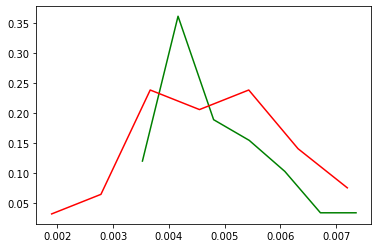

In [27]:
bins = 7
# loss distribution over the normal dataset
plot_hist(normal_losses,relative=True,color="g",bins=bins)
# loss distribution over the anomaly dataset 
plot_hist(anomaly_losses,relative=True,color="r",bins=bins)
plt.show()

### Evaluating the loss based approach

58
threshold:0.000,dn:1.000000 + ua:0.130435 = 0.565217
threshold:0.050,dn:0.965517 + ua:0.282609 = 0.624063
threshold:0.100,dn:0.913793 + ua:0.304348 = 0.609070
threshold:0.150,dn:0.862069 + ua:0.336957 = 0.599513
threshold:0.200,dn:0.810345 + ua:0.347826 = 0.579085
threshold:0.250,dn:0.758621 + ua:0.380435 = 0.569528
threshold:0.300,dn:0.706897 + ua:0.413043 = 0.559970
threshold:0.350,dn:0.655172 + ua:0.434783 = 0.544978
threshold:0.400,dn:0.603448 + ua:0.434783 = 0.519115
threshold:0.450,dn:0.551724 + ua:0.445652 = 0.498688
threshold:0.500,dn:0.500000 + ua:0.478261 = 0.489130
threshold:0.550,dn:0.465517 + ua:0.478261 = 0.471889
threshold:0.600,dn:0.413793 + ua:0.510870 = 0.462331
threshold:0.650,dn:0.362069 + ua:0.543478 = 0.452774
threshold:0.700,dn:0.310345 + ua:0.663043 = 0.486694
threshold:0.750,dn:0.258621 + ua:0.695652 = 0.477136
threshold:0.800,dn:0.206897 + ua:0.717391 = 0.462144
threshold:0.850,dn:0.155172 + ua:0.836957 = 0.496064
threshold:0.900,dn:0.103448 + ua:0.858696 =

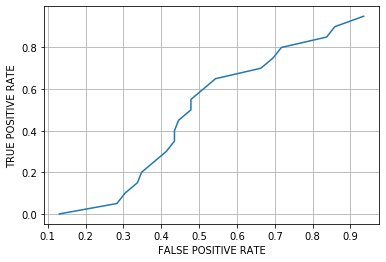

(0.65, 0.004925283440560218)

In [28]:
# x:= "false detected anomalies in %"
# y:= "correct detected normal data points in %"
FPs = FNs = []
prec = 20  # precision for getting the best threshold value
step_size = 1.0 / prec
TPs = np.arange(0, 1, step_size)
samples_anomaly = np.array(list(img_generator(X_anomaly_test, len(X_anomaly_test))))
samples_normal = np.array(list(img_generator(X_normal_test, len(X_normal_test))))

sorted_losses = np.sort(normal_losses)
print(len(sorted_losses))
for i in TPs:
    # loss value for detection of i*100 percent normal data points
    loss_boundary = sorted_losses[int(len(normal_losses) * i)]
    detected_normals = samples_normal[normal_losses >= loss_boundary]
    undetected_anomalies = samples_anomaly[anomaly_losses < loss_boundary]

    FP_rate = len(undetected_anomalies) / len(
        anomaly_losses
    )  # ratio between not detected loss values for anomalies
    FN_rate = len(detected_normals) / len(
        normal_losses
    )  # ratio between not detected loss values for anomalies

    FPs = np.append(FPs, FP_rate)  # not detected anomalies
    FNs = np.append(FNs, FN_rate)  # as anomalies detected normalities
    if (FP_rate + FN_rate) / 2 <= min(
        (FNs + FPs) / 2
    ):  # less or equal since we want the biggest TP_rate (i)
        loss_threshold = i
        best_boundary = loss_boundary

    # print every 1/10 threshold step
    if (int(i * prec)) % (prec // 20) == 0:
        print(
            "threshold:%.3f,dn:%f + ua:%f = %f"
            % (i, FN_rate, FP_rate, (FN_rate + FP_rate) / 2)
        )
    # minimum value for FN_rate + FP_rate (least relative amount of falsely detected)

plt.plot(FPs, TPs)
plt.grid()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.show()
loss_threshold, best_boundary

In [30]:
detected_normals =samples_normal[normal_losses >= best_boundary]  # values on the boundary are seen as anomalies
undetected_anomalies =samples_anomaly[anomaly_losses < best_boundary]
len(detected_normals), len(undetected_anomalies)

(21, 50)

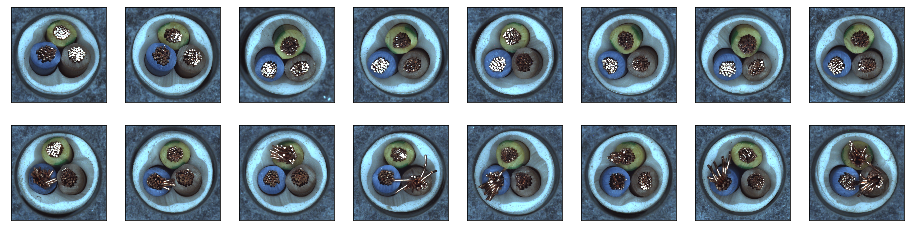

In [31]:
plot_samples(detected_normals,undetected_anomalies,plot_mvtec, os.path.join(img_path,"wrong-{}.png".format(USE_CASE)))

### Predicting with the reconstruction loss approach

In [32]:
def is_anomaly(X,boundary):
    rec_img = ae.predict(X.reshape(1,*X.shape))
    loss =  loss_per_img(rec_img,X)
    print(loss)
    return loss > boundary

In [33]:
this_should_be_false = is_anomaly(samples_normal[-1], best_boundary)
this_should_be_true = is_anomaly(samples_anomaly[-1], best_boundary)
this_should_be_false, this_should_be_true

0.006685881949506759
0.004335302654532285


(True, False)

## One Class SVM approach

In [363]:
from sklearn import svm
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score,accuracy_score

In [366]:
encoded_normal_imgs_train = encoder.predict_generator(
    train_img_generator(X_normal_train, 4), steps=len(X_normal_train)
)  # used later for One Class Classification
encoded_normal_imgs_test = encoder.predict_generator(
    train_img_generator(X_normal_test, 4), steps=len(X_normal_test)
)

In [369]:
encoded_normal_imgs_train = encoded_normal_imgs_train.reshape(
            -1, np.prod(encoded_normal_imgs_train.shape[1:])
        )
encoded_normal_imgs_test = encoded_normal_imgs_test.reshape(
            -1, np.prod(encoded_normal_imgs_test.shape[1:])
        )
encoded_anomaly_imgs = encoded_anomaly_imgs.reshape(-1, np.prod(encoded_anomaly_imgs.shape[1:]))
best_metrics =0,0,0
for i in np.arange(0.1, 1, 0.1):
    clf = svm.OneClassSVM(gamma="auto", nu=i)
    clf.fit(encoded_normal_imgs_train)
    
    score_normal = clf.predict(encoded_normal_imgs_test)
    bins = 2
    # hist_normal = np.histogram(score_normal, bins)
    # t = np.linspace(score_normal.min(), score_normal.max(), bins)
    # plt.bar(t, hist_normal[0], width=0.5, color="g")
    # plt.show()

    score_anomaly = clf.predict(encoded_anomaly_imgs)

    # hist_anomaly = np.histogram(score_anomaly, bins)
    # t = np.linspace(score_anomaly.min(), score_anomaly.max(), bins)
    # plt.bar(t, hist_anomaly[0], width=0.5, color="r")
    # plt.show()


    TP = len(score_normal[score_normal == 1])
    FN = len(score_normal[score_normal == -1])

    TN = len(score_anomaly[score_anomaly == -1])
    FP = len(score_anomaly[score_anomaly == 1])
    accuracy = (TP + TN) / (len(score_normal) + len(score_anomaly))
    precision = TP / (TP + FN)
    recall = TP / (TP + FP)
    if (accuracy,precision,recall) > best_metrics:
        best_nu = i
        best_metrics = accuracy,precision,recall
        oc_svm = clf
    print("%.2f" % i, accuracy, precision, recall)
best_nu,best_metrics

0.10 0.7482517482517482 0.7 0.8235294117647058
0.20 0.7692307692307693 0.7 0.8615384615384616
0.30 0.7272727272727273 0.5625 0.9183673469387755
0.40 0.6363636363636364 0.3875 0.9117647058823529
0.50 0.5804195804195804 0.2875 0.8846153846153846
0.60 0.5804195804195804 0.2875 0.8846153846153846
0.70 0.5174825174825175 0.175 0.8235294117647058
0.80 0.48951048951048953 0.0875 1.0
0.90 0.48951048951048953 0.0875 1.0


(0.2, (0.7692307692307693, 0.7, 0.8615384615384616))

In [370]:
def is_anomaly_svm(X,oc_svm):
    X = X.reshape((1,X.shape[0]))
    prediction = oc_svm.predict(X)[0]
    return prediction == -1

In [371]:
this_should_be_false_svm = is_anomaly_svm(encoded_normal_imgs_train[0], oc_svm)
this_should_be_true_svm = is_anomaly_svm(encoded_anomaly_imgs[0], oc_svm)
this_should_be_false_svm, this_should_be_true_svm

(False, False)

# TODO: Encoded feature analysis with our friend CF Gauss

In [146]:
flat_shape = np.prod(encoded_normal_imgs_train.shape[1:], dtype=np.int64)
encoded_normal_imgs_train = encoded_normal_imgs_train.reshape(
    len(encoded_normal_imgs_train), flat_shape
)
encoded_normal_imgs_test = encoded_normal_imgs_test.reshape(
    len(encoded_normal_imgs_test), flat_shape
)

In [147]:
def gauss(x_i, my_i, sigma_i2):
    # gaussian distribution for one feature
    if sigma_i2 == 0:
        return 1 if x_i == my_i else 0
    return np.array(
        (1 / np.sqrt(2 * np.pi * sigma_i2))
        * np.exp(-(x_i - my_i) ** 2 / (2 * sigma_i2))
    )

In [148]:
def my(X):
    return np.array([(1 / len(x)) * np.sum(x) for x in X.T])

In [149]:
def sigma2(X, my):
    # computes sigma squared for each feature
    m = len(X)  # number of data points
    return np.array([(1/m)*np.sum((X[:, i] - my[i]) ** 2) for i in range(len(my))])

In [150]:
def p(X,my,sigma2):
    return np.array([np.prod([gauss(x[i], my[i], sigma2[i])
               for i in range(len(x))]) for x in X])

In [156]:
X= encoded_normal_imgs_test
m = len(X)
number_of_features = len(X[0])
my = np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 = np.array(
    [np.sum((X[:, i] - my[i]) ** 2) / m for i in range(number_of_features)]
)

p_all = p(X, my, sigma_2)
my

array([1.99189777, 0.        , 2.20821114, ..., 0.53145118, 1.85000763,
       0.30248611])

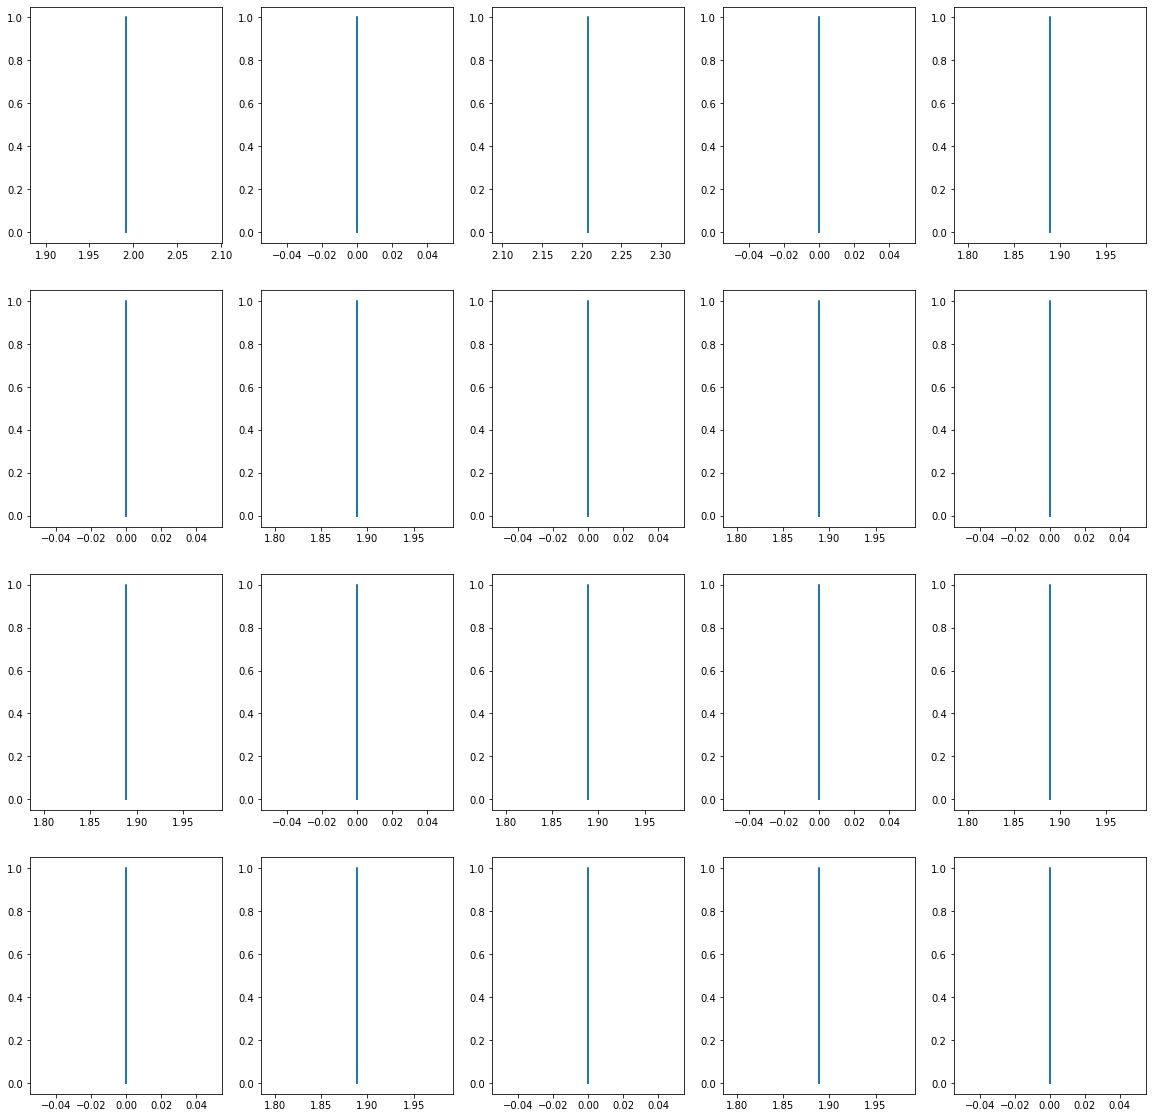

In [158]:
plt.figure(figsize=(20, 20))
for i in range(20):
    # plots distribution of i-th feature
    # display original
    bins = 20
    hist = np.histogram(X[:, i], bins=bins)
    ax = plt.subplot(4, 5, i + 1)
    r = np.linspace(start=min(X[:, i]), stop=max(X[:, i]), num=bins)
    plt.plot(r, hist[0]/len(X[:,i]))

In [ ]:
X= encoded_anomaly_imgs
m = len(X)
number_of_features = len(X[0])
my = np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 = np.array(
    [np.sum((X[:, i] - my[i]) ** 2) / m for i in range(number_of_features)]
)

p_all = p(X, my, sigma_2)
plt.figure(figsize=(20, 20))
for i in range(len(my)-1):
    # plots distribution of i-th feature
    # display original
    bins = 20
    hist = np.histogram(X[:, i], bins=bins)
    ax = plt.subplot(4, 6, i + 1)
    r = np.linspace(start=min(X[:, i]), stop=max(X[:, i]), num=bins)
    plt.plot(r, hist[0]/len(X[:,i]))